# Classification with PyTorch/TensorFlow

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

## Part 1: Iris Classification

Iris Dataset contains 150 records of 3 different classes of irises. Each record contains 4 numeric parameters: sepal length/width and petal length/width. It is an example of a simple dataset, for which you do not need a powerful neural network.

### Getting the Dataset

Iris dataset is build into Scikit Learn, so we can easily get it:

In [1]:
from sklearn.datasets import load_iris
#from sklearn.model_selection import train_test_split

iris = load_iris()
features = iris['data']
labels = iris['target']
class_names = iris['target_names']
feature_names = iris['feature_names']

print(f"Features: {feature_names}, Classes: {class_names}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], Classes: ['setosa' 'versicolor' 'virginica']


### Visualize the Data

In many cases, it makes sense to visualize the data to see if they look separable - it would assure us that we should be able to build good classification model. Because we have a few features, we can build a series of pairwise 2D scatter plots, showing different classes by different dot colors. This can be automatically done by a package called **seaborn**:

In [2]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(features,columns=feature_names).join(pd.DataFrame(labels,columns=['Label']))

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


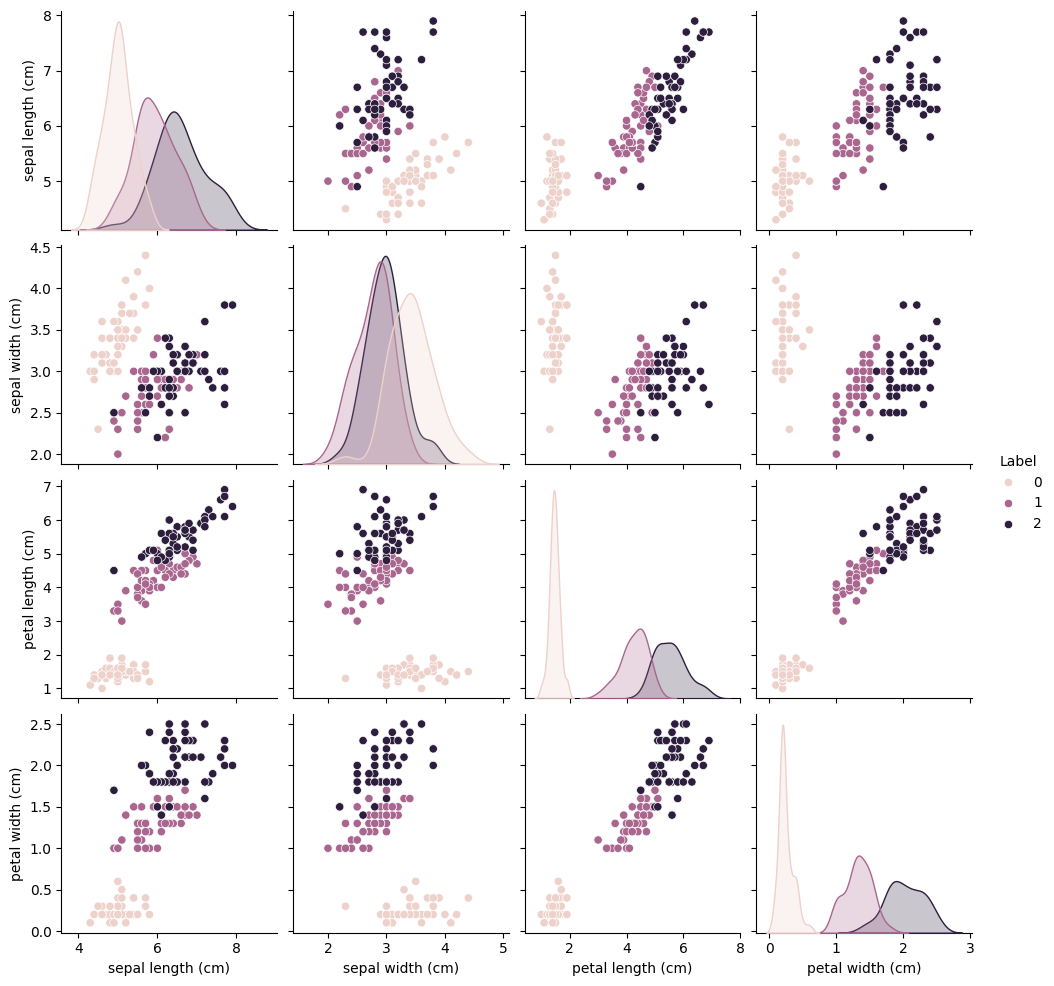

In [3]:
sns.pairplot(df,hue='Label')

### Normalize and Encode the Data

To prepare data to neural network training, we need to normalize inputs in the range [0,1]. We do this using plain `numpy` operations.

Since PyTorch allows you to feed in class number  as an integer (from 0 to N-1) we do not transform the labels. After transforming the normalized features and labels into PyTorch tensors we load it into a Dataset class.
``` 

In [4]:
import torch
import torch.utils.data as data_utils
import torch.nn as nn

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

features_max = features.max(axis=0, keepdims=True)
features_min = features.min(axis=0, keepdims=True)
normalized_features = (features-features_min)/(features_max-features_min)

features_tensor = torch.Tensor(normalized_features)
labels_tensor = torch.Tensor(labels).type(torch.LongTensor)
dataset = data_utils.TensorDataset(features_tensor, labels_tensor)


### Split the Data into Train and Test

We still need to split the dataset in train data and test data. We use the `random_split` function in PyTorch for this.

In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = data_utils.random_split(dataset,[train_size, test_size])

batch_size = 10
train_loader = data_utils.DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = data_utils.DataLoader(test_data, batch_size=10, shuffle=True)

### Define and Train Neural Network

The assignment suggested that we use a neural network with one, two or three layers. These are implemented below. We chose to use relatively large hidden layers, as these seem to give good results.

In [6]:
class OneLayerNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4,3)

    def forward(self, x):
        x=self.linear1(x)
        return x
    
class TwoLayerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4,50)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(50,3)

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        return x
    
class ThreeLayernet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4,50)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(50,50)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(50,3)

    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear2(x))
        x = self.linear3(x)
        return x

The following two funtions implement the training loop. One function trains the model for one epoch and the other function implements the whole training cycle.

In [7]:
def train_epoch(model, loss_fn, dataloader, optimizer):
    epoch_loss=[]
    running_loss = 0.0
    for j, data in enumerate(dataloader):
            features, labels = data

            optimizer.zero_grad()

            preds = model(features)
            batch_loss = loss_fn(preds, labels)
            batch_loss.backward()
            optimizer.step()

            epoch_loss.append(batch_loss.item())
            running_loss+=batch_loss.item()
            if j%5==4:
                print(f"batch {j+1}, loss: {running_loss/5}")
                running_loss = 0.0
    return epoch_loss

def train_model(model, loss_fn,train_loader, test_loader, optimizer,no_of_epochs):
    train_loss = []
    val_loss = []
    accuracy = []
    epoch_number = 1
    for epoch in range(no_of_epochs):
        #epoch_loss = []
        print(f"EPOCH {epoch_number}:")
        model.train(True)
        epoch_loss = train_epoch(model,loss_fn, train_loader, optimizer)
        train_loss+=epoch_loss
            
        running_vloss = 0.0
        model.eval()
        with torch.no_grad():
             for i, vdata in enumerate(test_loader):
                  vfeatures, vlabels = vdata
                  vpred = model(vfeatures)
                  vloss = loss_fn(vpred,vlabels)
                  correct = (torch.argmax(vpred, dim=1) == vlabels).type(torch.FloatTensor)
                  val_loss.append(vloss.item())
                  running_vloss+=vloss.item()
                  accuracy.append(correct.mean().item())
        

        val_loss.append(running_vloss/(i+1))
        train_loss+=epoch_loss
        print(f"LOSS train {epoch_loss[-1]}, val: {val_loss[-1]}")

        epoch_number+=1
    return train_loss, val_loss, accuracy
    

Now we are ready to train the models. We will train for 50 epochs.

In [8]:
no_of_epochs = 50
net1 = OneLayerNet()
loss_fn = torch.nn.CrossEntropyLoss()
optim1 = torch.optim.SGD(net1.parameters(), lr=0.01, momentum=0.9)

train_loss1, val_loss1, acc1 = train_model(net1,loss_fn,train_loader,test_loader,optim1, no_of_epochs)


EPOCH 1:
batch 5, loss: 1.1991146326065063
batch 10, loss: 1.1927886486053467
LOSS train 1.1572916507720947, val: 1.16665518283844
EPOCH 2:
batch 5, loss: 1.1551628351211547
batch 10, loss: 1.0921799182891845
LOSS train 1.0165367126464844, val: 1.105323314666748
EPOCH 3:
batch 5, loss: 1.056473708152771
batch 10, loss: 1.0501851201057435
LOSS train 1.0553014278411865, val: 1.0502284963925679
EPOCH 4:
batch 5, loss: 1.0146681785583496
batch 10, loss: 0.9975005388259888
LOSS train 0.9118760824203491, val: 0.9957947134971619
EPOCH 5:
batch 5, loss: 0.9664894461631774
batch 10, loss: 0.9354765892028809
LOSS train 1.039406657218933, val: 0.9512362082799276
EPOCH 6:
batch 5, loss: 0.9772660851478576
batch 10, loss: 0.875336492061615
LOSS train 0.8339881896972656, val: 0.8982658386230469
EPOCH 7:
batch 5, loss: 0.8848015427589416
batch 10, loss: 0.8757017374038696
LOSS train 0.8758382797241211, val: 0.8564430673917135
EPOCH 8:
batch 5, loss: 0.885868513584137
batch 10, loss: 0.796881449222564

In [9]:
no_of_epochs = 50
net2 = TwoLayerNet()
optim2 = torch.optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)

train_loss2, val_loss2, acc2 = train_model(net2,loss_fn,train_loader,test_loader,optim2, no_of_epochs)

EPOCH 1:
batch 5, loss: 1.1274171352386475
batch 10, loss: 1.093337106704712
LOSS train 1.0438138246536255, val: 1.0249402125676472
EPOCH 2:
batch 5, loss: 1.0164565205574037
batch 10, loss: 0.9598187804222107
LOSS train 0.9368499517440796, val: 0.9252598683039347
EPOCH 3:
batch 5, loss: 0.8980223894119262
batch 10, loss: 0.8632476091384887
LOSS train 0.9113432765007019, val: 0.8063369790712992
EPOCH 4:
batch 5, loss: 0.7889050364494323
batch 10, loss: 0.7526916265487671
LOSS train 0.7841082215309143, val: 0.6996052265167236
EPOCH 5:
batch 5, loss: 0.6917727947235107
batch 10, loss: 0.691000759601593
LOSS train 0.7181611061096191, val: 0.6135523915290833
EPOCH 6:
batch 5, loss: 0.6427601218223572
batch 10, loss: 0.5853705167770386
LOSS train 0.5628303289413452, val: 0.542433500289917
EPOCH 7:
batch 5, loss: 0.5412176489830017
batch 10, loss: 0.575597494840622
LOSS train 0.49303072690963745, val: 0.48834002017974854
EPOCH 8:
batch 5, loss: 0.548364669084549
batch 10, loss: 0.48012606501

In [10]:
no_of_epochs = 50
net3 = ThreeLayernet()
#loss_fn = torch.nn.CrossEntropyLoss()
optim3 = torch.optim.SGD(net3.parameters(), lr=0.01, momentum=0.9)

train_loss3, val_loss3, acc3 = train_model(net3,loss_fn,train_loader,test_loader,optim3, no_of_epochs)

EPOCH 1:
batch 5, loss: 1.1013334751129151
batch 10, loss: 1.0981524467468262
LOSS train 1.0876564979553223, val: 1.0881470044453938
EPOCH 2:
batch 5, loss: 1.0712182760238647
batch 10, loss: 1.0640185832977296
LOSS train 1.0369832515716553, val: 1.0511807600657146
EPOCH 3:
batch 5, loss: 1.0271868705749512
batch 10, loss: 1.0301034688949584
LOSS train 1.0341832637786865, val: 1.006270170211792
EPOCH 4:
batch 5, loss: 0.9978503108024597
batch 10, loss: 0.9527870059013367
LOSS train 0.8956656455993652, val: 0.9179594318072001
EPOCH 5:
batch 5, loss: 0.9183998227119445
batch 10, loss: 0.8560992002487182
LOSS train 0.7401509284973145, val: 0.7972301642100016
EPOCH 6:
batch 5, loss: 0.7843429684638977
batch 10, loss: 0.75066579580307
LOSS train 0.5884816646575928, val: 0.6457566817601522
EPOCH 7:
batch 5, loss: 0.583026671409607
batch 10, loss: 0.6809410810470581
LOSS train 0.7501240968704224, val: 0.515808234612147
EPOCH 8:
batch 5, loss: 0.5683777689933777
batch 10, loss: 0.4825058341026

### Plot of results

Below we plot the training and validation loss as well as the accuracy of the classification. All models show good convergence with increasing performance as the number of layers increases.

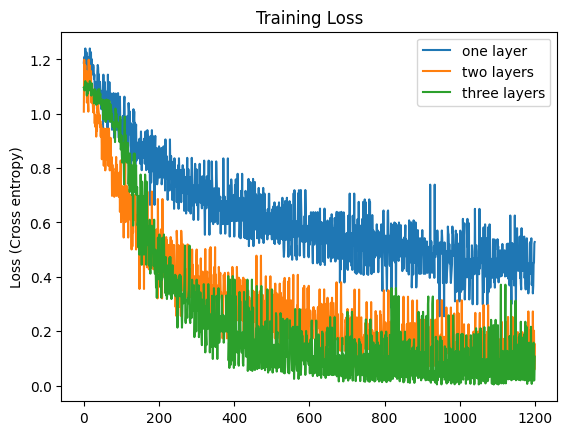

In [11]:
from matplotlib import pyplot as plt
plt.plot(train_loss1, label='one layer')
plt.plot(train_loss2, label='two layers')
plt.plot(train_loss3, label='three layers')
plt.ylabel("Loss (Cross entropy)")
plt.title("Training Loss")
plt.legend()


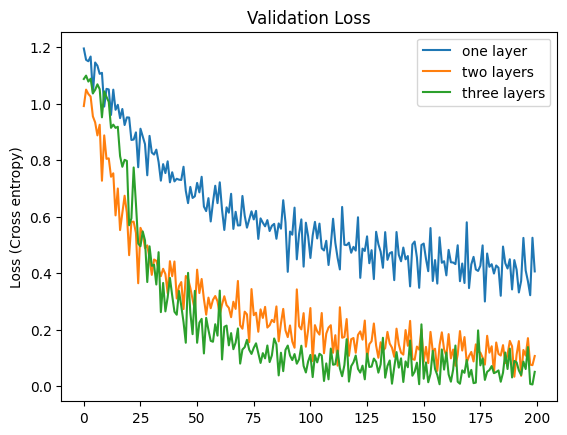

In [12]:
plt.plot(val_loss1, label='one layer')
plt.plot(val_loss2, label='two layers')
plt.plot(val_loss3, label='three layers')
plt.ylabel("Loss (Cross entropy)")
plt.title("Validation Loss")
plt.legend()

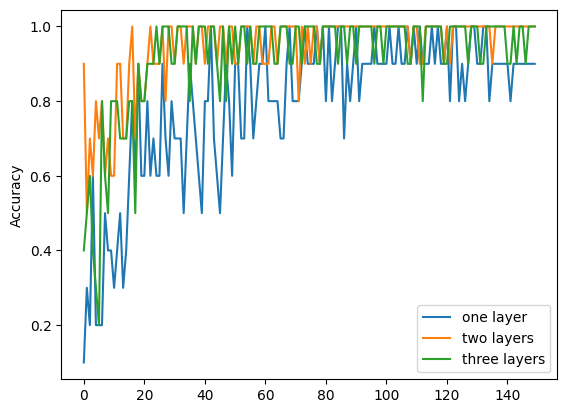

In [13]:
from matplotlib import pyplot as plt
plt.plot(acc1, label='one layer')
plt.plot(acc2, label='two layers')
plt.plot(acc3, label='three layers')
plt.ylabel("Accuracy")
#plt.title("Training Loss")
plt.legend()

## Part 2: MNIST Training

Both Keras and PyTorch contain MNIST as built-in dataset, so you can easily get it with a couple of lines of code ([Keras](https://keras.io/api/datasets/mnist/), [PyTorch](https://pytorch.org/vision/stable/datasets.html)). You will also be able to load both train and test datasets without manually splitting them.

In [16]:
import torchvision
import torchvision.transforms as tf

transform = tf.ToTensor()

mnist_dataset_train = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
mnist_dataset_test = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)

Now you need to perform the steps above to make sure dataset is normalized (it would probably already be), defining and training a neural network.

## Takeaway

1. Neural networks can be used for traditional machine learning tasks. However, they are in many cases too powerful, and can cause overfitting.
1. It is important in this assignment that you observe the overfitting behavior, and try to avoid it.
1. With frameworks like Keras, sometimes training a neural network is quite straightforward. But you need to understand what goes on.